In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
import sys
parent_dir = os.path.abspath("..")  # Moves one level up
sys.path.append(parent_dir)

from utils.MatrixVectorizer import MatrixVectorizer
from MLP import LRtoHRMLP

In [2]:
def train(model, X_train, y_train, X_val, y_val, epochs: int = 1, batch_size: int = 32, patience: int = 20):
    """
    Train the MLP to map LR to HR data
    
    Args:
        epochs (int): Maximum number of training epochs
        batch_size (int): Size of mini-batches
        patience (int): Early stopping patience
    """
    
    # Loss function (Mean Squared Error is typical for regression)
    criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(
        model.parameters(), 
        lr=0.001, 
        weight_decay=1e-5  # L2 regularization
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=10, 
        verbose=True
    )
    
    # Training loop with early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        # Training mode
        model.train()
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                # Optionally save best model
                # torch.save(model.state_dict(), 'baseline_mlp_model.pth')
            else:
                epochs_no_improve += 1
            
            # Print progress
            if epoch % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], '
                        f'Train Loss: {loss.item():.4f}, '
                        f'Val Loss: {val_loss.item():.4f}')
            
            # Early stopping condition
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

def test(model, X_val, Y_val, criterion = nn.MSELoss()):
    """
    Predict high-resolution data from low-resolution input
    Args:
        lr_test_data (np.ndarray): Low-resolution test data
    Returns:
        np.ndarray: Predicted high-resolution data
    """
    # Scale input data
    
    # Prediction
    model.eval()
    with torch.no_grad():
        hr_scaled_pred = model(X_val).numpy()
        mse_loss = criterion(hr_scaled_pred, Y_val)
    

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import networkx as nx

In [4]:
def evaluation_metrics(pred_matrices, gt_matrices):
    # Initialize lists to store MAEs for each centrality measure
    # post-processing
    pred_matrices[pred_matrices < 0] = 0
    gt_matrices[gt_matrices < 0] = 0

    mae_bc = []
    mae_ec = []
    mae_pc = []
    mae_sp = []
    mae_ac = []
    num_test_samples = len(pred_matrices)
    pred_1d_list = []
    gt_1d_list = []

    # Iterate over each test sample
    for i in range(num_test_samples):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices[i], edge_attr="weight")
        gt_graph = nx.from_numpy_array(gt_matrices[i], edge_attr="weight")
        
        ## Inverse the weights of edges for SPL, as higher weights means stronger connectivity 
        inv_pred_graph = nx.from_numpy_array(1 - pred_matrices[i] + 1e-4, edge_attr="weight")
        inv_gt_graph = nx.from_numpy_array(1 - gt_matrices[i] + 1e-4, edge_attr="weight")

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")
        pred_sp = nx.average_shortest_path_length(inv_pred_graph, weight="weight")
        pred_ac = nx.average_clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")
        gt_sp = nx.average_shortest_path_length(inv_gt_graph, weight="weight")
        gt_ac = nx.average_clustering(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_pc_values = list(pred_pc.values())
   

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_pc_values = list(gt_pc.values())

        # Compute MAEs
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))
        mae_sp.append(abs(pred_sp - gt_sp))
        mae_ac.append(abs(pred_ac - gt_ac))

        # Vectorize matrices
        pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(gt_matrices[i]))

    # Compute average MAEs
    avg_mae_bc = sum(mae_bc) / len(mae_bc)
    avg_mae_ec = sum(mae_ec) / len(mae_ec)
    avg_mae_pc = sum(mae_pc) / len(mae_pc)
    avg_diff_sp = sum(mae_sp) / len(mae_sp)
    avg_diff_ac = sum(mae_ac) / len(mae_ac)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute metrics /
    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    print("Average MAE betweenness centrality:", avg_mae_bc)
    print("Average MAE eigenvector centrality:", avg_mae_ec)
    print("Average MAE PageRank centrality:", avg_mae_pc)
    print("Average shorter path absolute error:", avg_diff_sp)
    print("Average clustering absolute error", avg_diff_ac)

    return mae, pcc, js_dis, avg_mae_bc, avg_mae_ec, avg_mae_pc, avg_diff_sp, avg_diff_ac

In [5]:
# Initialize model
lr_train_arr = np.loadtxt('../lr_train.csv', delimiter=',', skiprows=1)
hr_train_arr = np.loadtxt('../hr_train.csv', delimiter=',', skiprows=1)
matrix_vectorizer = MatrixVectorizer()

input_dim = lr_train_arr.shape[1]
output_dim = hr_train_arr.shape[1]

device = "cuda:0"

kf = KFold(n_splits=3, shuffle=True, random_state=42)


In [6]:
i = 1
for train_index, val_index in kf.split(lr_train_arr):
    model = LRtoHRMLP(
        input_dim=input_dim, 
        output_dim=output_dim
    ).to(device)

    X_train, X_val = lr_train_arr[train_index], lr_train_arr[val_index]
    Y_train, Y_val = hr_train_arr[train_index], hr_train_arr[val_index]
    
    X_train = torch.FloatTensor(X_train).to(device)
    Y_train = torch.FloatTensor(Y_train).to(device)
    X_val   = torch.FloatTensor(X_val).to(device)
    Y_val = torch.FloatTensor(Y_val).to(device)

    train(model, X_train, Y_train, X_val, Y_val, epochs=50)
    
    torch.save(model.state_dict(), f"./baselineMLP-fold-{i}.pth")
    print()
    i +=1 

/home/kup/code/dgl-cw2/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.0483, Val Loss: 0.0815
Epoch [11/50], Train Loss: 0.0172, Val Loss: 0.0277
Epoch [21/50], Train Loss: 0.0045, Val Loss: 0.0267
Epoch [31/50], Train Loss: 0.0032, Val Loss: 0.0263
Epoch [41/50], Train Loss: 0.0028, Val Loss: 0.0259

Epoch [1/50], Train Loss: 0.0418, Val Loss: 0.0784
Epoch [11/50], Train Loss: 0.0149, Val Loss: 0.0307
Epoch [21/50], Train Loss: 0.0052, Val Loss: 0.0302
Epoch [31/50], Train Loss: 0.0038, Val Loss: 0.0296
Epoch [41/50], Train Loss: 0.0031, Val Loss: 0.0287

Epoch [1/50], Train Loss: 0.0446, Val Loss: 0.0836
Epoch [11/50], Train Loss: 0.0190, Val Loss: 0.0282
Epoch [21/50], Train Loss: 0.0054, Val Loss: 0.0273
Epoch [31/50], Train Loss: 0.0038, Val Loss: 0.0272
Epoch [41/50], Train Loss: 0.0033, Val Loss: 0.0266



In [11]:
evaluation_across_folds = []
trained_models = []
i = 1
for train_index, val_index in kf.split(lr_train_arr):
    print(f"Evaluating Fold {i}")
    
    model = LRtoHRMLP(
        input_dim=input_dim, 
        output_dim=output_dim
    ).to(device)
    
    state_dict = torch.load(f"./baselineMLP-fold-{i}.pth")
    model.load_state_dict(state_dict)
    i +=1
    
    X_val =  lr_train_arr[val_index]
    Y_val =  hr_train_arr[val_index]
    
    model.eval()
    with torch.no_grad():
        hr_train_preds = model(torch.FloatTensor(X_val).to(device))

    hr_train_labels = np.array([matrix_vectorizer.anti_vectorize(hr, 268) for hr in Y_val])
    hr_train_preds = np.array([matrix_vectorizer.anti_vectorize(hr, 268) for hr in hr_train_preds])
    
    
    MLP_metrics = evaluation_metrics(hr_train_preds, hr_train_labels)
    evaluation_across_folds.append(MLP_metrics)
    
    

Evaluating Fold 1
MAE:  0.1313427804947401
PCC:  0.6863846432997968
Jensen-Shannon Distance:  0.27788943736498556
Average MAE betweenness centrality: 0.017740521961452347
Average MAE eigenvector centrality: 0.012508054682460856
Average MAE PageRank centrality: 0.0005236709699882315
Average shorter path absolute error: 0.03337414416915147
Average clustering absolute error 0.02758938594801747
Evaluating Fold 2
MAE:  0.14036414616210552
PCC:  0.6764592659269437
Jensen-Shannon Distance:  0.2876691975553231
Average MAE betweenness centrality: 0.0182958864543549
Average MAE eigenvector centrality: 0.013152830359992651
Average MAE PageRank centrality: 0.0005318865235577031
Average shorter path absolute error: 0.03982704802737075
Average clustering absolute error 0.04892737332842385
Evaluating Fold 3
MAE:  0.13360662838445395
PCC:  0.6882422834091975
Jensen-Shannon Distance:  0.27833585270446126
Average MAE betweenness centrality: 0.018186718530505214
Average MAE eigenvector centrality: 0.0124

In [7]:
evaluation_across_folds = np.load('3-fold-mlp-evaluation_data.npy')

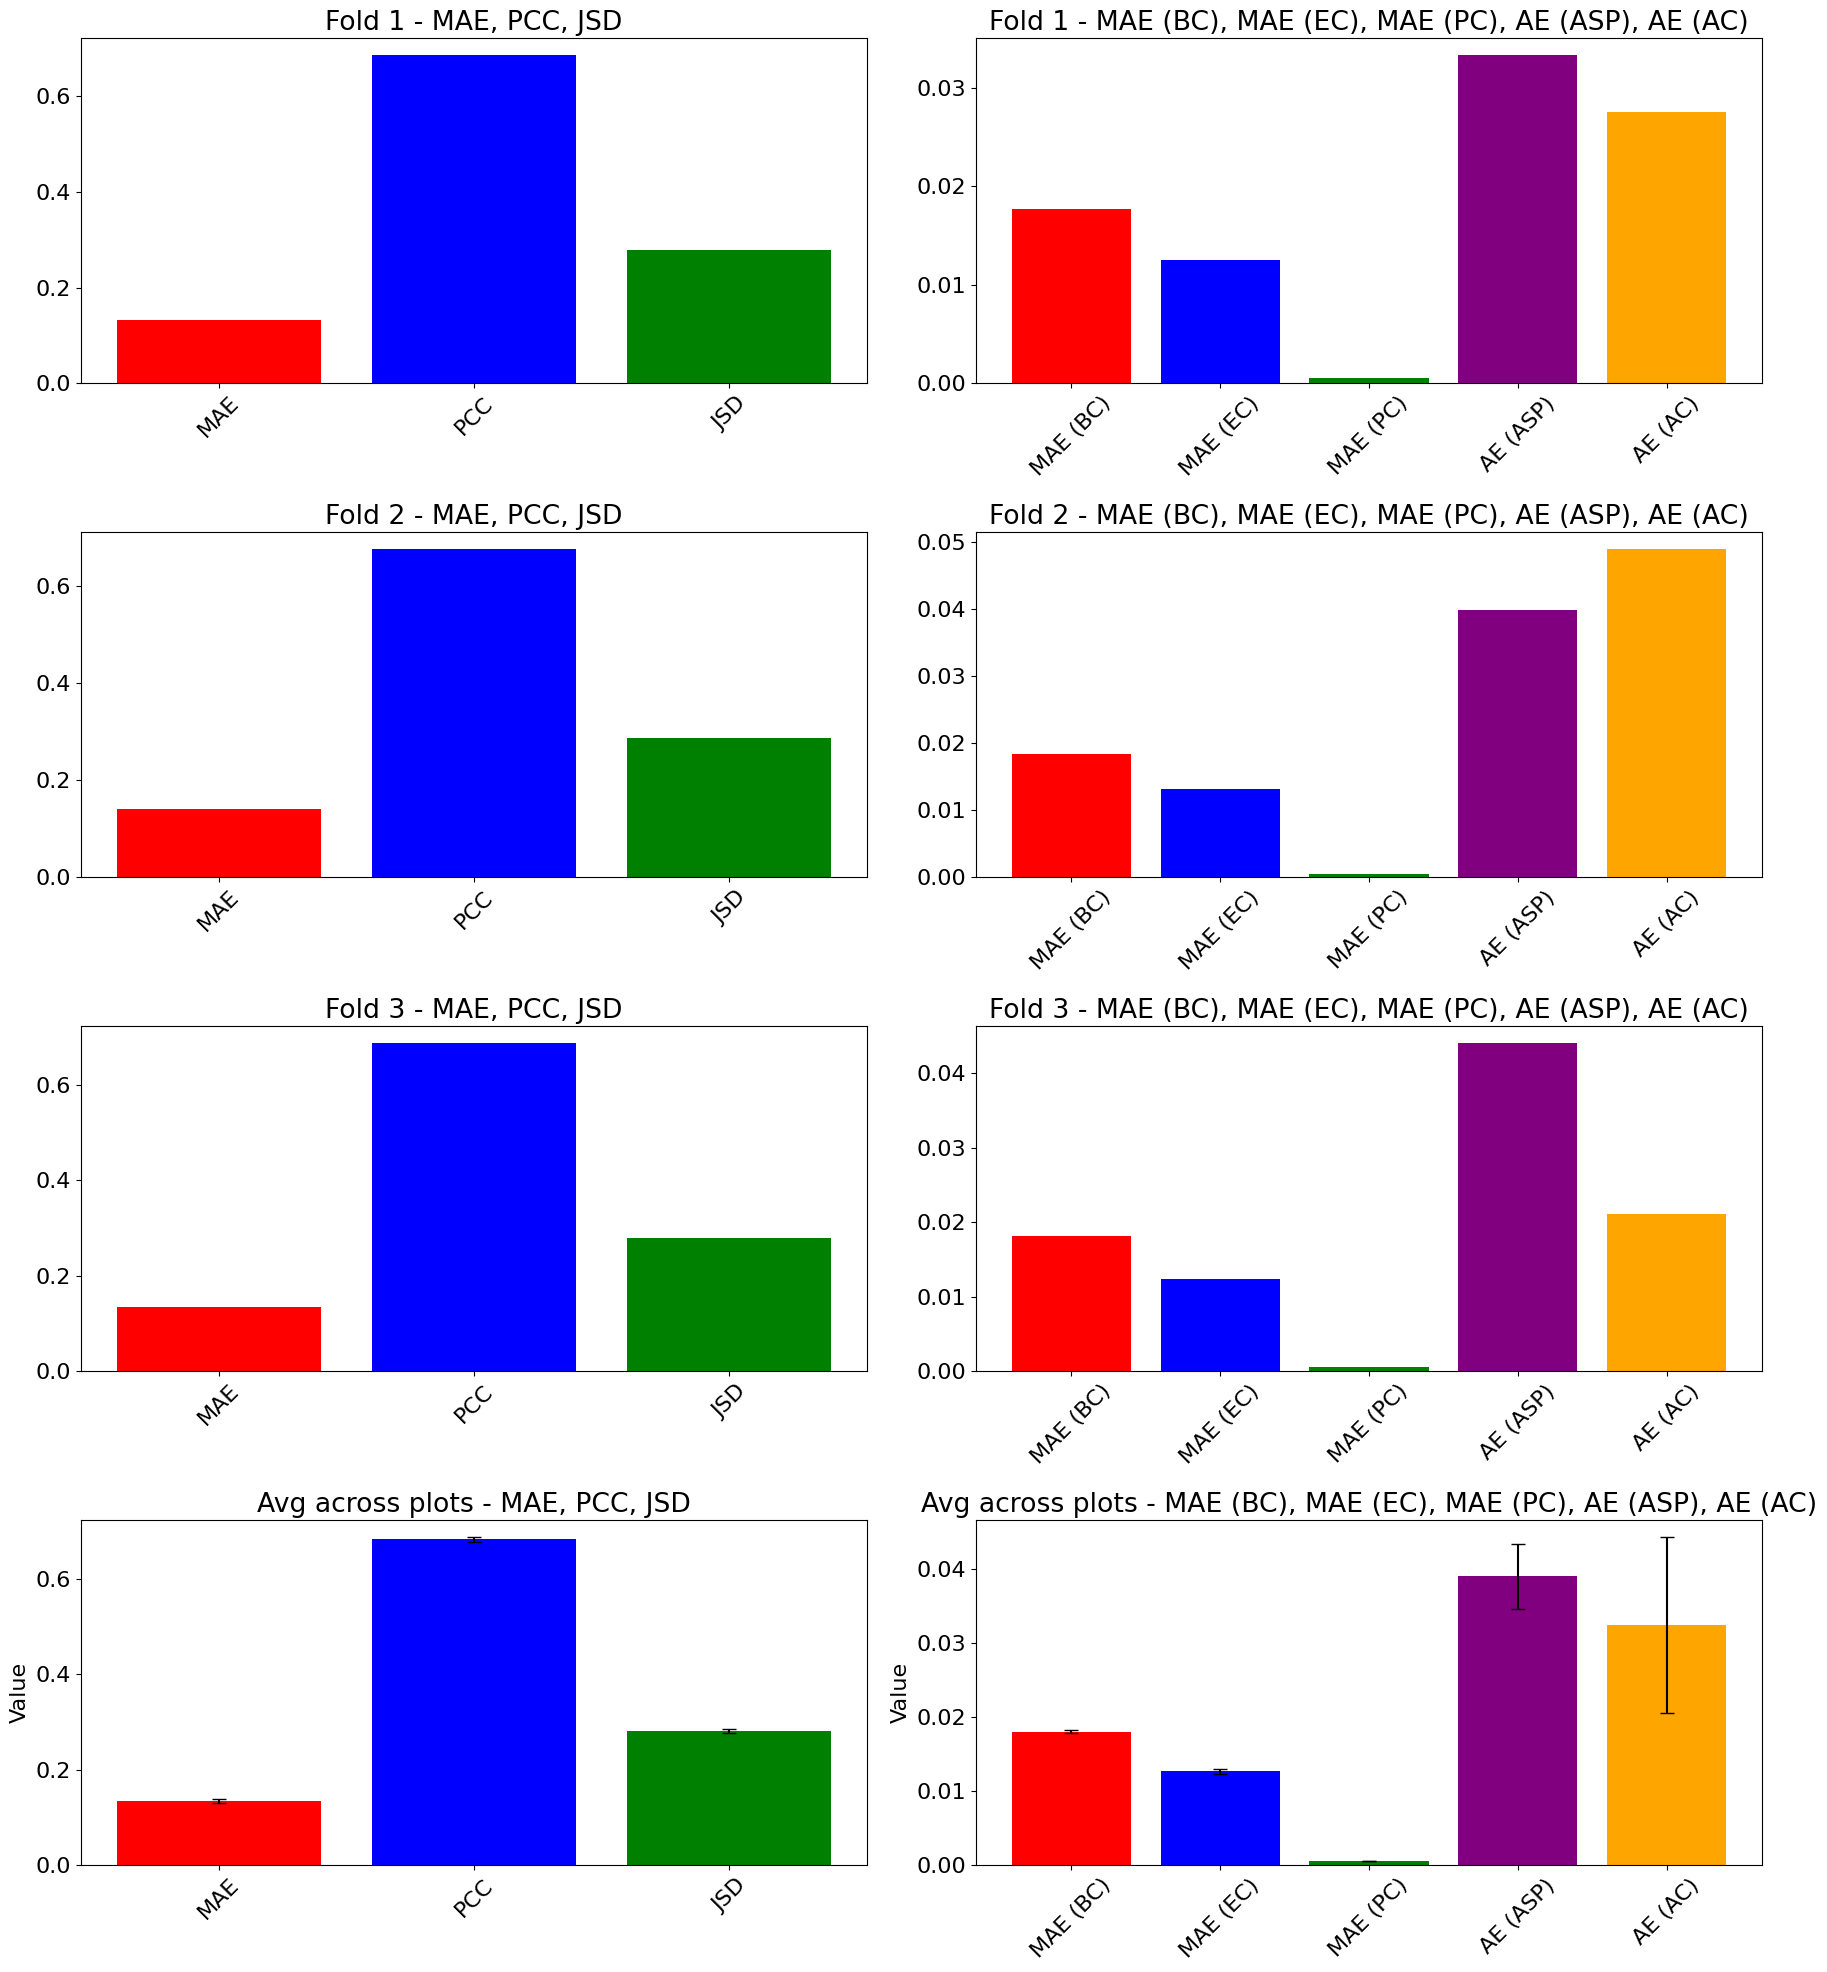

In [16]:
# Sample data: Three lists, each with tuples of length 8
# Compute means and standard deviations
data_array = np.array(evaluation_across_folds)  
plt.rcParams.update({'font.size': 16})

# Number of categories
categories = ["MAE", "PCC", "JSD", "MAE (BC)", "MAE (EC)", "MAE (PC)", "AE (ASP)", "AE (AC)"]
colors = ["red", "blue", "green", "purple", "orange", "pink", "brown", "cyan"]
x = np.arange(len(categories))
slice1 = slice(0, 3)
slice2 = slice(3, 8)
# Plot individual bar graphs for each tuple
fig, axes = plt.subplots(4, 2, figsize=(18, 20))

axes[0, 0].bar(x[:3], data_array[0][slice1], color=colors)
axes[0, 0].set_title(f"Fold 1 - MAE, PCC, JSD")
axes[0, 0].set_xticks(x[:3])
axes[0, 0].set_xticklabels(categories[:3], rotation=45)

axes[0, 1].bar(x[3:], data_array[0][slice2], color=colors)
axes[0, 1].set_title(f"Fold 1 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[0, 1].set_xticks(x[3:])
axes[0, 1].set_xticklabels(categories[3:], rotation=45)

axes[1, 0].bar(x[:3], data_array[1][slice1], color=colors)
axes[1, 0].set_title(f"Fold 2 - MAE, PCC, JSD")
axes[1, 0].set_xticks(x[:3])
axes[1, 0].set_xticklabels(categories[:3], rotation=45)

axes[1, 1].bar(x[3:], data_array[1][slice2], color=colors)
axes[1, 1].set_title(f"Fold 2 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[1, 1].set_xticks(x[3:])
axes[1, 1].set_xticklabels(categories[3:], rotation=45)

axes[2, 0].bar(x[:3], data_array[2][slice1], color=colors)
axes[2, 0].set_title(f"Fold 3 - MAE, PCC, JSD")
axes[2, 0].set_xticks(x[:3])
axes[2, 0].set_xticklabels(categories[:3], rotation=45)

axes[2, 1].bar(x[3:], data_array[2][slice2], color=colors)
axes[2, 1].set_title(f"Fold 3 - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[2, 1].set_xticks(x[3:])
axes[2, 1].set_xticklabels(categories[3:], rotation=45)

# Compute the average and standard deviation across the three tuples for each category
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)

# Plot the average bar graph with error bars for the standard deviation
axes[3, 0].bar(x[:3], mean_values[:3], yerr=std_values[:3], capsize=5, color=colors)
axes[3, 0].set_title("Avg across plots - MAE, PCC, JSD")
axes[3, 0].set_xticks(x[:3])
axes[3, 0].set_xticklabels(categories[:3], rotation=45)
axes[3, 0].set_ylabel("Value")

axes[3, 1].bar(x[3:], mean_values[3:], yerr=std_values[3:], capsize=5, color=colors)
axes[3, 1].set_title("Avg across plots - MAE (BC), MAE (EC), MAE (PC), AE (ASP), AE (AC)")
axes[3, 1].set_xticks(x[3:])
axes[3, 1].set_xticklabels(categories[3:], rotation=45)
axes[3, 1].set_ylabel("Value")
plt.tight_layout()
plt.show()